In [2]:
# bypass a problem with R reading of https connections
remote.file = function(URL) {
    temporaryFile <- tempfile()
    download.file(URL,destfile=temporaryFile, method="curl")
    return( temporaryFile )
}

URL = "https://raw.githubusercontent.com/sidooms/MovieTweetings/master/latest/ratings.dat"
Ratings = read.table( remote.file(URL), sep = ":", header=FALSE )[,c(1,3,5,7)]
colnames(Ratings) = c("UserID", "MovieID", "Rating", "TwitterID")
  #download MovieTweetings dataset

not.installed = function(package_name)  !is.element(package_name, installed.packages()[,1])
if (not.installed("MASS")) install.packages("MASS")
library(MASS)

In [24]:
Distribution = c( "normal", "t", "cauchy", "negative binomial", "logistic", "weibull", "beta")
  # include negatively skewed distributions here
  # chi-squared, lognormal, gamma, exponential are positively skewed distribution
Find_fitting_distribution = function(Dataset) {
    temp_name = ""
    temp_parameter = ""
    temp_likelihood = -Inf

    for (i in 1:length(Distribution)) {
        dist_name = Distribution[i]
        #if (Distribution_can_have_negative_values[i] || Dataset_is_nonnegative) {
            # do not try to fit a nonnegative distribution to data that is negative

            if (dist_name == "weibull") {
                # fitdistr requires special handling of weibull
                RescaledDataset = (Dataset + runif(length(Dataset)))*10/11
                fit = suppressWarnings( fitdistr( RescaledDataset, dist_name ))
            } 
            else if (dist_name == "beta") {
                UnroundedDataset = Dataset + runif(length(Dataset))
                #  The range of (Ratings + UniformNoise) should be the open interval (0,11)
                
                RescaledDataset = UnroundedDataset / 11.0
                # These range of these rescaled ratings should be the open interval (0,1)
                #The following then has a chance of working .... with good constants  a > b:
                
                if (all(Dataset >= 0) && all(Dataset <= 1) ) {
                    fit = suppressWarnings( fitdistr( RescasledDataset, dist_name,
                                   start=list(shape1=0.5, shape2=0.5) ))
                }
            } 
            else {
                fit = suppressWarnings( fitdistr( Dataset, dist_name ) )
            }

            fitted_parameters = fit$estimate
            log_likelihood = fit$loglik

            parameter_value_string = paste(round(fitted_parameters), collapse=" ")
            # print integer parameters
            cat(sprintf("%s %s %s\n", dist_name, parameter_value_string, log_likelihood))

            # The optimal distribution is the one with maximum-likelihood
            #  (and:  maximum-likelihood == maximum-log-likelihood).
            # The optimal distribution needs to be tracked here .............
            if (round(log_likelihood) > temp_likelihood) {
                temp_name = dist_name
                temp_parameter = parameter_value_string
                temp_likelihood = round(log_likelihood)
                #cat(sprintf("%s %s %s\n", temp_name, temp_parameter, temp_likelihood))
            }
        #}
    }
    }
Find_fitting_distribution(Ratings$Rating)

normal 7 2 -1000881.14258505
t 7 2 7 -994102.686508939
cauchy 8 1 -1060768.93206291
negative binomial 3034 7 -1067749.72372339
logistic 7 1 -994168.702405072
weibull 5 8 -950166.801865511
beta 5 8 -950166.801865511


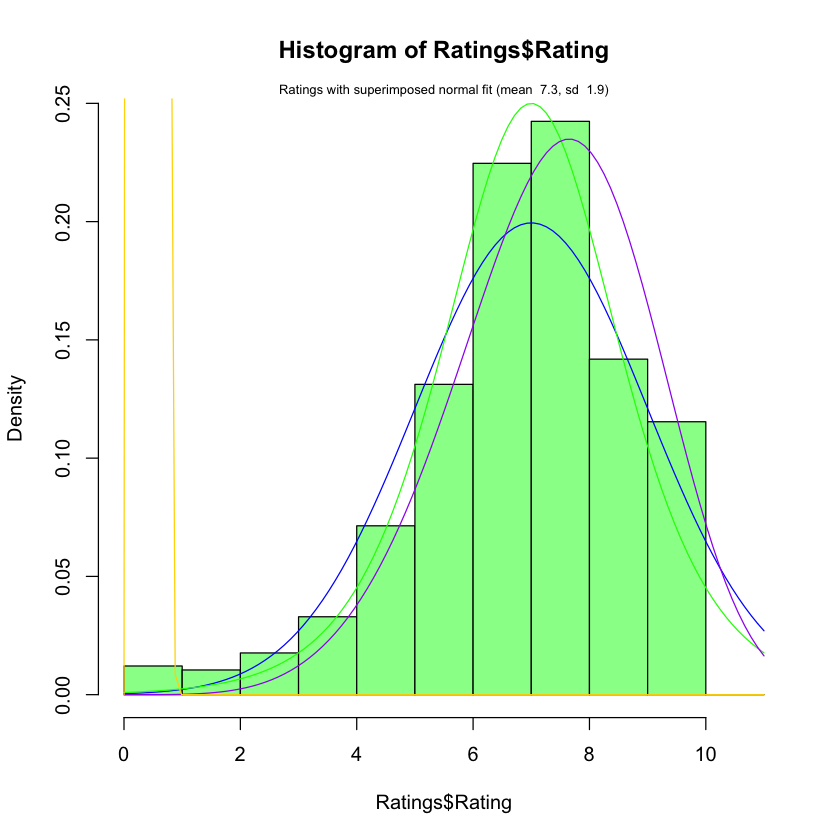

In [19]:
hist( Ratings$Rating, probability=TRUE, col="palegreen", breaks=0:11 )

rating_avg = mean(Ratings$Rating)
rating_sd  = sd(Ratings$Rating)

curve( dnorm(x, 7, 2), col="blue", add=TRUE )  #  add a curve with the normal MLE
curve( dlogis(x, 7,1), col="green", add=TRUE)
curve( dweibull(x, 5, 8), col="purple", add=TRUE)
curve( dbeta(x, 5, 8), col="gold", add=TRUE)

In [35]:
    #compute_skewness = function(Dataset, parameters) mean(((Dataset- parameters[1]) / parameters[2])^3)
    Dataset_mean = mean(Dataset)
    compute_skewness = function(Dataset) mean((Dataset-Dataset_mean)^3)/(mean((Dataset-Dataset_mean)^2))^(3/2)
    compute_skewness(Dataset)                        

[1] -0.83434

In [36]:
     compute_kurtosis = function(Dataset) mean((Dataset-Dataset_mean)^4)/(mean((Dataset-Dataset_mean)^2))^2 
     compute_kurtosis(Dataset)

[1] 3.9749

In [5]:
NumberOfRatings = data.frame(aggregate( Rating ~ MovieID, length, data=Ratings ))
colnames(NumberOfRatings) = c("MovieID", "NumberOfRatings")
# get trending moview
TrendingMovies = subset( NumberOfRatings, NumberOfRatings > 50 )
# join of tables as MovieID, userID, rating, twitterID, numberOfRatings
RatingsOfTrendingMovies = merge( Ratings, TrendingMovies, by="MovieID" ) 
# get the average and median rating for each movie
AveragedRatingsOfTrendingMovies = aggregate( Rating ~ MovieID, mean, data=RatingsOfTrendingMovies )
MedianRatingsOfTrendingMovies = aggregate( Rating ~ MovieID, median, data=RatingsOfTrendingMovies )

# get max average movie
maxAveragedRating = max(AveragedRatingsOfTrendingMovies$Rating)
HotTrendingMovies = subset(AveragedRatingsOfTrendingMovies, Rating == maxAveragedRating)
HotTrendingMovies 
# get large difference movie
DiffRatingsOfTrendingMovies = data.frame(MedianRatingsOfTrendingMovies$MovieID, abs(MedianRatingsOfTrendingMovies$Rating - AveragedRatingsOfTrendingMovies$Rating))
colnames(DiffRatingsOfTrendingMovies) = c("MovieID", "DifferenceOfRatings")
maxDiff = max(abs(MedianRatingsOfTrendingMovies$Rating - AveragedRatingsOfTrendingMovies$Rating))
DiffTrendingMovies = subset(DiffRatingsOfTrendingMovies, DifferenceOfRatings == maxDiff)
DiffTrendingMovies
# Question 4 ???get name
HotTrendingMovieRating = subset(RatingsOfTrendingMovies, MovieID == HotTrendingMovies$MovieID[1])
head(HotTrendingMovieRating)
HotTrendingMovieAverageRating = mean(HotTrendingMovieRating$Rating)
HotTrendingMovieAverageRating
HotTrendingMovieMedianRating = median(HotTrendingMovieRating$Rating)
HotTrendingMovieMedianRating

#Question 5
DiffTrendingMovieRating = subset(RatingsOfTrendingMovies, MovieID == DiffTrendingMovies$MovieID[1])
head(DiffTrendingMovieRating)
DiffTrendingMovieAverageRating = mean(DiffTrendingMovieRating$Rating)
DiffTrendingMovieAverageRating
DiffTrendingMovieMedianRating = median(DiffTrendingMovieRating$Rating)
DiffTrendingMovieMedianRating

,MovieID,Rating
191,111161,9.436496


,MovieID,DifferenceOfRatings
1460,2515086,2.433628


,MovieID,UserID,Rating,TwitterID,NumberOfRatings
20216,111161,1500,8,1388609237,685
20217,111161,2234,10,1362872553,685
20218,111161,38147,10,1432572725,685
20219,111161,11060,5,1410151057,685
20220,111161,33975,9,1419450628,685
20221,111161,206,10,1441127837,685


[1] 9.436496

[1] 10

,MovieID,UserID,Rating,TwitterID,NumberOfRatings
329589,2515086,26346,6,1386713419,113
329590,2515086,7246,1,1377766917,113
329591,2515086,34272,5,1377872855,113
329592,2515086,12221,10,1378561220,113
329593,2515086,18879,10,1386273774,113
329594,2515086,30519,10,1377959052,113


[1] 6.566372

[1] 9

In [15]:
#HotTrendingMovies = subset(AveragedRatingsOfTrendingMovies, Rating == maxAveragedRating)
# download name and genre information 
URL = "https://raw.githubusercontent.com/sidooms/MovieTweetings/master/latest/movies.dat"
MovieText = readLines( remote.file(URL) )
Movies = matrix( sapply( MovieText,
                function(x) unlist(strsplit(sub(" [(]([0-9]+)[)]", "::\\1",x),"::"))[1:4] ),
                nrow=length(MovieText), ncol=4, byrow=TRUE )

Movies = data.frame(Movies)
colnames(Movies) = c("MovieID", "MovieTitle", "Year", "Genres")
HotTrendingMovieName = subset(Movies, MovieID == HotTrendingMovies$MovieID[1])
HotTrendingMovieName$MovieTitle
DiffTrendingMovieName = subset(Movies, MovieID == DiffTrendingMovies$MovieID[1])
DiffTrendingMovieName$MovieTitle                
#Ratings_and_Movies = merge( RatingsOfTrendingMovies, Movies, by="MovieID" )   
    
                    
                    # joing ratings              
#cat(sprintf("Name of the movie with the highest Average Rating is %s", HotTrendingMovies[1]$))

factor(0)
23699 Levels: -- And Now the Screaming Starts! -197°C Murder ... Þrestir

[1] This Is Us
23699 Levels: -- And Now the Screaming Starts! -197°C Murder ... Þrestir

In [20]:
#  source is at: https://github.com/hadley/ggplot2movies

if (not.installed("ggplot2")) install.packages("ggplot2")

library(ggplot2)

data(movies)

[1] 58788    24

In [26]:
Distribution = c( "normal", "t", "cauchy", "logistic", "weibull", "beta")
Find_fitting_distribution(movies$rating)

normal 6 2 -109295.02853236
t 6 2 35 -109273.037631389
cauchy 6 1 -118614.996183483
logistic 6 1 -109522.501502727
weibull 5 6 -104077.708487505
beta 5 6 -104077.708487505


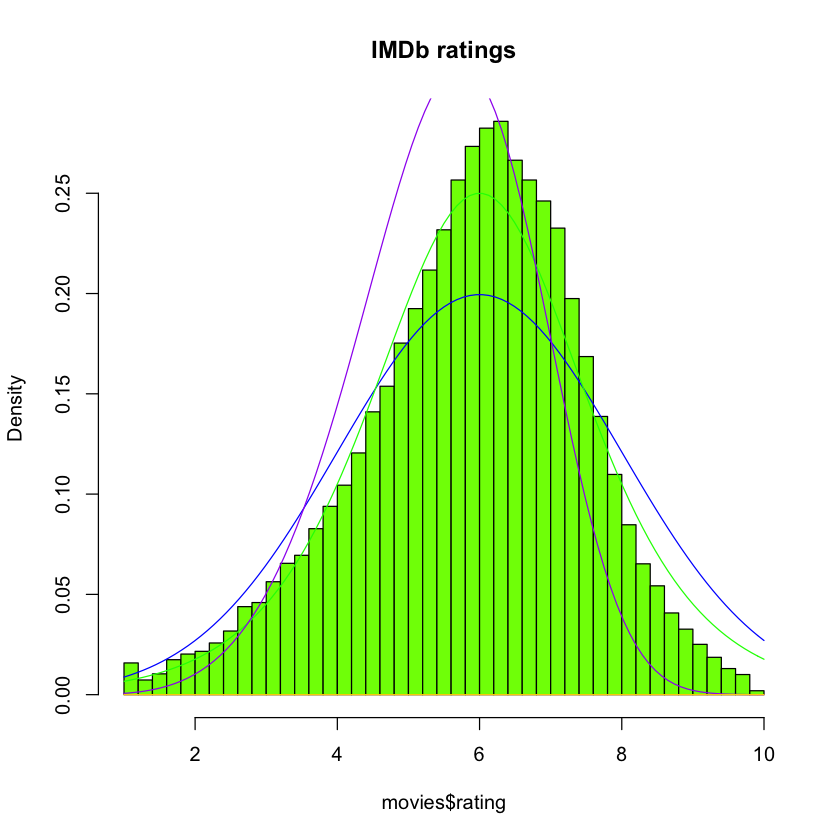

In [32]:
hist( movies$rating, probability=TRUE, col="lawngreen", main="IMDb ratings", breaks=50 )

curve( dnorm(x, 6, 2), col="blue", add=TRUE )  #  add a curve with the normal MLE
curve( dlogis(x, 6, 1), col="green", add=TRUE)
curve( dweibull(x, 5, 6), col="purple", add=TRUE)
curve( dbeta(x, 5, 6), col="gold", add=TRUE)

In [38]:
compute_skewness(movies$rating)
compute_kurtosis(movies$rating)

[1] -1.576644

[1] 3.105635

In [40]:
cat(sprintf("(5)"))

(5)

In [ ]:
cat(sprintf("True"))